In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext rpy2.ipython

# import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import seaborn as sns
from sklearn.metrics import mean_squared_error
# from sklearn.decomposition import FactorAnalysis
from factor_analyzer import factor_analyzer
import pandas as pd
# import scipy.stats as stats
# from sklearn.decomposition import PCA

sys.path.insert(0, 'src')
import utils
import visualizations
import analysis

### Helper Functions

In [2]:
# Python self implmented functions
def normalize_data(data):
    '''
    Data should be shape n_items x  n_participants
    '''

    assert data.shape[0] < data.shape[1], "data had shape ({}), should it be transposed?".format(data.shape)

    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()
        
    n_items, n_participants = data.shape
    means = np.mean(data, axis=1, keepdims=True)  # Calculate mean for each item
    sds = np.std(data, axis=1, keepdims=True, ddof=1)  # Calculate std for each item
    
    assert means.shape == (n_items, 1)
    assert sds.shape == (n_items, 1)

    normalized_data = (data - means) / sds
    assert normalized_data.shape == data.shape
    # print(np.mean(normalized_data))
    return normalized_data

def compute_factor_scores(responses, 
                          loadings,
                          return_predictions):
    '''
    Calculates factor scores based on Thurstone method 
        * https://personality-project.org/r/psych/help/factor.scores.html
        * https://pmc.ncbi.nlm.nih.gov/articles/PMC3773873/


    Arg(s):
        responses : n_items x n_participants
            UN-normalized responses, normalization will occur in this function
        loadings : n_items x n_factors
        
    Returns:
        factor_scores : n_factors x n_participants
        predictions (opt) : n_items x n_participants
    '''
    assert responses.shape[0] < responses.shape[1], "responses had shape ({}), should it be transposed?".format(responses.shape)
    # Normalize responses if not already normalized
    if np.mean(responses) > 1e-5:
        responses = normalize_data(responses)
        utils.informal_log("Normalizing responses")
    else:
        utils.informal_log("Not normalizing responses")
    
    # Calculate correlation coefficient
    lambda_ = np.corrcoef(responses, rowvar=True) # n_items x n_items
    lambda_inv = np.linalg.inv(lambda_)
    weights = lambda_inv @ loadings # n_items x n_factors
    factor_scores = weights.T @ responses # n_factors x n_participants

    if return_predictions:
        predictions = loadings @ factor_scores
        return factor_scores, predictions
    return factor_scores

# Assign factor categories
def assign_categories(df,
                      item_colname,
                      save_dir=None,
                      overwrite=True):
    if save_dir is not None:
        save_path = os.path.join(save_dir, 'loading_w_factors.csv')
        dict_save_path = os.path.join(save_dir, 'fa_groupings.json')
        if os.path.exists(save_path) and \
            dict_save_path and \
            not overwrite:
            utils.informal_log("Files exists in {}".format(save_dir))
            return utils.read_file(save_path), utils.read_file(dict_save_path)
        
    items = df[item_colname]
    factor_df = df.drop(columns=item_colname)
    factor_df['factor'] = factor_df.idxmax(axis=1)
    factor_df[item_colname] = items

    groupings_dict = {}
    for factor in sorted(factor_df['factor'].unique()):
        row_items = factor_df[factor_df['factor'] == factor]['item'].to_list()
        groupings_dict[factor] = row_items

    if save_dir is not None:
        utils.write_file(factor_df, save_path, overwrite=overwrite)
        utils.write_file({'factor_analysis': groupings_dict}, dict_save_path, overwrite=overwrite)
    return factor_df

def sort_by_loadings(loading_df,
                     factors,
                     factor_colname='factor',
                     item_colname='item'):
    '''
    Factors should actually be in REVERSE order because of how the heatmap presents items
    '''
    item_order = []
    for factor in factors:
        temp = loading_df[loading_df[factor_colname] == '{}'.format(factor)]
        temp = temp.sort_values(by='{}'.format(factor), axis=0, ascending=True)
        item_order += temp[item_colname].to_list()

    return item_order


In [5]:
%%R

normalize_data = function(df) {
    # '''
    # df : n_participants x n_items array
    # '''
    # Calculate factor scores based on modified loadings
    mus <- colMeans(df)
    sigmas <- apply(df, 2, sd) # calculate `sd` over all columns (2 is for columns)

    scaled_df = scale(df, mus, sigmas)
    return(scaled_df)
}

compute_factor_scores <- function(data, loadings) {
    # '''
    # Arg(s):
    #     data : unnormalized n_participants x n_items
    #     loadings : n_items x n_factors matrix

    # Utilize Thurstone method of computing factor scores
    #     * https://personality-project.org/r/psych/help/factor.scores.html
    #     * https://pmc.ncbi.nlm.nih.gov/articles/PMC3773873/ (Eq1)
    
    # '''
    data <- normalize_data(data) # n_participants x n_items

    lambda_inv <- solve(cor(data)) # n_items x n_items
    weights <- lambda_inv %*% loadings # n_items x n_factors
    factor_scores <- data %*% weights # n_participants x n_factors
    predictions <- factor_scores %*% t(loadings)

    # Ensure that predictions and data have the same dimensions
    stopifnot(dim(predictions) == dim(data))

    mse <- mean((predictions - data) ^ 2)
    
    return(list(factor_scores = factor_scores, predictions = predictions))

}

k_fold_mse <- function(rating_df, k,
                       rotate, fm, scores, seed,
                       save_dir, overwrite, save_loadings = FALSE) {

    if (!is.null(save_dir)) {
        
        metrics_save_path <- sprintf('%s/k_fold_overall_metrics.json', save_dir)
        fold_metrics_save_path <- sprintf('%s/fold_metrics.csv', save_dir)
        if (file.exists(metrics_save_path) && 
            file.exists(fold_metrics_save_path) && !overwrite) {
            print(sprintf("File exists at %s", metrics_save_path))
            # return(metrics_save_path)
            return(list(
                metrics=fromJSON(metrics_save_path), 
                fold_metrics=read.csv(fold_metrics_save_path)))
        }
    }
    fold_size = ceiling(nrow(rating_df) / k)
    print(sprintf("With %d folds and %d rows, %d rows per fold", k, nrow(rating_df), fold_size))
    # shuffle data
    set.seed(seed)
    shuffled_idxs <- sample(nrow(rating_df))
    
    # Initialize empty lists
    all_test <- list()
    all_predictions <- list()

    metric_df = data.frame()

    # Iterate through folds
    for (k_idx in seq(1:k)) {
        test_idxs <- shuffled_idxs[(((k_idx-1)*fold_size)+1):(k_idx*fold_size)]
        test <- rating_df[test_idxs,]
        # Exclude test idxs
        train = rating_df[-test_idxs,]

        fa_results = fa(
            r = train,
            nfactors = n_factors,
            rotate = rotate,
            fm = fm,
            scores = scores)
        
        
        # Get factor scores and predictions
        loadings <- fa_results$loadings
        scores_result <- compute_factor_scores(
            data = test,
            loadings = loadings
        )
        predictions <- scores_result$predictions

        normalized_test <- normalize_data(test)

        # Calculate fold's MSE and BIC
        bic <- fa_results[['BIC']]
        mse <- mean((normalized_test - predictions) ^ 2)
        metric_df <- bind_rows(
            metric_df, 
            data.frame(fold = k_idx,
            bic = bic,
            mse = mse)
        )

        # Add to lists
        all_test[[k_idx]] <- normalized_test
        all_predictions[[k_idx]] <- predictions

        # Save loadings
        if (save_loadings) {
            loading_save_path <- sprintf("%s/loadings_fold%d.csv", save_dir, k_idx)
            print(sprintf("Saving loadings to %s", loading_save_path))
            write.csv(loadings, loading_save_path)
        }

    }

    # Concatenate along rows
    all_test <- do.call(rbind, all_test)
    all_predictions <- do.call(rbind, all_predictions)

    mse <- mean((all_test - all_predictions) ^2)

    metrics <- list(
        mse = mse
    )
    if (!is.null(save_dir)) {
        write(toJSON(metrics), metrics_save_path)
        print(sprintf("Saving metrics to %s", metrics_save_path))

        write.csv(metric_df, fold_metrics_save_path)
        print(sprintf("Saving fold-level metrics to %s", fold_metrics_save_path))
    }
    return(list(metrics=metrics, fold_metrics=metric_df))
}

# Utils
ensure_dir <- function(dirname) {
    if (!dir.exists(dirname)) {
        dir.create(dirname, recursive = TRUE) # recursive = TRUE creates parent directories if needed
        cat("Directory created:", dirname, "\n")
    } 
    else {
        cat("Directory already exists:", dirname, "\n")
    }
}

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/share/R/library’ contains no packages


### Define Paths and Variables

In [5]:
grouping_version = 'absolute_study4'
n_factors = 3

# K-fold
k = 5
max_n_factors = 6

rating_csv_path = 'data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_{}/ratings.csv'.format(grouping_version)
items_path = 'dependent_variables/randomized_dvs_40/shuffled_0.txt'
save_dir = os.path.join(os.path.dirname(rating_csv_path), 'decomposition', 'factor_analysis', '{}_components'.format(n_factors))

loading_csv_path = os.path.join(save_dir, 'loadings.csv')
# For graphing
item_order_path = os.path.join(os.path.dirname(rating_csv_path), 'R_results/emmeans_graphs/item_order.txt')
save_ext = 'svg'

# Theoretical groupings
groupings_path = 'dependent_variables/groupings_colombatto_{}.json'.format(grouping_version)
grouping_source = 'weisman'
weisman_loadings_path = 'dependent_variables/weisman_table1.csv'

utils.ensure_dir(save_dir)

# Data driven save dir
data_driven_save_dir = os.path.join(save_dir, 'data_fa')
utils.ensure_dir(data_driven_save_dir)

# K-fold save-dir
k_fold_save_dir = os.path.join(save_dir, 'kfold')
utils.ensure_dir(k_fold_save_dir)

# Using Weisman Loadings
overlap_fa_save_dir = os.path.join(save_dir, "overlap_items")
utils.ensure_dir(overlap_fa_save_dir)
weisman_loading_study = 1  # Which study to use factor loadings from

# Re-Run R analysis
loadings_R_dir = data_driven_save_dir
R_csv_dir = os.path.join(loadings_R_dir, 'R_csvs')
R_results_dir = os.path.join(loadings_R_dir, 'R_results')
item_level_R_results_dir = os.path.join(R_results_dir, 'item_level')
utils.ensure_dir(R_csv_dir)
utils.ensure_dir(R_results_dir)
utils.ensure_dir(item_level_R_results_dir)

In [7]:
# Load ratings and items and select columns for items
rating_df = utils.read_file(rating_csv_path)
items = utils.read_file(items_path)
rating_df = rating_df.loc[:, items]

groupings = utils.read_file(groupings_path)

assert(rating_df.shape == (470, 40))

normalized_ratings = pd.DataFrame(
    normalize_data(rating_df.to_numpy().T).T,
    columns=items)

utils.write_file(
    normalized_ratings,
    os.path.join(os.path.dirname(rating_csv_path), 'normalized_ratings.csv'),
    overwrite=False)

File at data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/normalized_ratings.csv exists and not overwriting


In [4]:
%%R
library(dplyr)
library(psych)
library(jsonlite)

n_factors <- 3
grouping_version <- 'absolute_study4'
# K-fold
k <- 5
max_n_factors <- 6
sample_seed <- 123

rating_csv_path <- sprintf('data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_%s/ratings.csv', grouping_version)
items_path <- sprintf('data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_%s/R_csvs/weisman_items.txt', grouping_version)

rating_df <- read.csv(rating_csv_path)
items <- readLines(items_path)

rating_df <- rating_df[, items]
stopifnot(dim(rating_df) == c(470, 40))

normalized_ratings <- normalize_data(rating_df)
print(dim(normalized_ratings))

# Factor Analysis parameters
rotate <- 'varimax'
fm <- 'ml'
scores <- 'Thurstone'

# Save dir
save_dir <- file.path(dirname(rating_csv_path), "decomposition", "factor_analysis", paste0(n_factors, "_components"))
ensure_dir(save_dir)

# Data driven save dir
data_driven_save_dir <- sprintf("%s/data_fa", save_dir)
ensure_dir(data_driven_save_dir)

# Kfold save dir 
k_fold_save_dir <- sprintf("%s/kfold", save_dir)
ensure_dir(k_fold_save_dir)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Error in normalize_data(rating_df) : 
  could not find function "normalize_data"
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/share/R/library’ contains no packages
Error in normalize_data(rating_df) : 
  could not find function "normalize_data"


RInterpreterError: Failed to parse and evaluate line 'library(dplyr)\nlibrary(psych)\nlibrary(jsonlite)\n\nn_factors <- 3\ngrouping_version <- \'absolute_study4\'\n# K-fold\nk <- 5\nmax_n_factors <- 6\nsample_seed <- 123\n\nrating_csv_path <- sprintf(\'data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_%s/ratings.csv\', grouping_version)\nitems_path <- sprintf(\'data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_%s/R_csvs/weisman_items.txt\', grouping_version)\n\nrating_df <- read.csv(rating_csv_path)\nitems <- readLines(items_path)\n\nrating_df <- rating_df[, items]\nstopifnot(dim(rating_df) == c(470, 40))\n\nnormalized_ratings <- normalize_data(rating_df)\nprint(dim(normalized_ratings))\n\n# Factor Analysis parameters\nrotate <- \'varimax\'\nfm <- \'ml\'\nscores <- \'Thurstone\'\n\n# Save dir\nsave_dir <- file.path(dirname(rating_csv_path), "decomposition", "factor_analysis", paste0(n_factors, "_components"))\nensure_dir(save_dir)\n\n# Data driven save dir\ndata_driven_save_dir <- sprintf("%s/data_fa", save_dir)\nensure_dir(data_driven_save_dir)\n\n# Kfold save dir \nk_fold_save_dir <- sprintf("%s/kfold", save_dir)\nensure_dir(k_fold_save_dir)\n'.
R error message: 'Error in normalize_data(rating_df) : \n  could not find function "normalize_data"'
R stdout:

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Error in normalize_data(rating_df) : 
  could not find function "normalize_data"
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/share/R/library’ contains no packages

### Factor Analysis

#### Data Driven Factor Analysis

In [53]:
%%R

data_driven_fa <- function(rating_df, n_factors, rotate, fm, scores, 
                  save_dir = NULL, overwrite = FALSE) {
    if (!is.null(save_dir)) {
        loadings_save_path <- sprintf("%s/loadings.csv", save_dir)
        factor_scores_save_path <- sprintf("%s/factor_scores_T.csv", save_dir)
        predictions_save_path <- sprintf("%s/predictions_T.csv", save_dir)
        metrics_save_path <- sprintf("%s/metrics.json", save_dir)
        if (file.exists(loadings_save_path) && 
            file.exists(factor_scores_save_path) && 
            file.exists(predictions_save_path) && 
            file.exists(metrics_save_path) && 
            !overwrite) {
            cat("Files already exist in :", save_dir, "\n")

            return(list(
                loadings = read.csv(loadings_save_path),
                factor_scores = read.csv(factor_scores_save_path),
                predictions = read.csv(predictions_save_path),
                metrics = fromJSON(metrics_save_path)
            ))
        }
    }
    fa_results <- fa(
        r = rating_df,
        rotate = rotate,
        fm = fm,
        scores = scores,
        nfactors = n_factors
    )

    normalized_ratings <- normalize_data(rating_df)
    predictions <- fa_results$scores %*% t(fa_results$loadings)
    bic <- fa_results[['BIC']]
    mse <- mean((normalized_ratings - predictions) ^2)
    metrics <- list(
        bic = bic,
        mse = mse,
        variance = fa_results$Vaccounted,
        var_explained = fa_results$Vaccounted[3, n_factors]
    )
    # Save to files
    if (!is.null(save_dir)) {
        write.csv(fa_results$loadings, loadings_save_path)
        write.csv(fa_results$scores, factor_scores_save_path)
        write.csv(predictions, predictions_save_path)
        write_json(metrics, metrics_save_path)
        print(sprintf("Saved files in %s", save_dir))
    }
    
    return(list(
        loadings = fa_results$loadings,
        factor_scores = fa_results$scores,
        predictions = predictions,
        metrics = metrics
    ))
}

In [54]:
%%R

data_driven_fa_results <- data_driven_fa(
    rating_df = rating_df,
    n_factors = n_factors,
    rotate = rotate,
    fm = fm, 
    scores = scores, 
    save_dir = data_driven_save_dir,
    overwrite = TRUE
)
print(data_driven_fa_results$metrics)


[1] "Saved files in data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/4_components/data_fa"
$bic
[1] -2443.407

$mse
[1] 0.4843322

$variance
                            ML1       ML2        ML4        ML3
SS loadings           9.8029576 5.0533301 2.96176868 1.34766780
Proportion Var        0.2450739 0.1263333 0.07404422 0.03369169
Cumulative Var        0.2450739 0.3714072 0.44545141 0.47914310
Proportion Explained  0.5114838 0.2636650 0.15453466 0.07031656
Cumulative Proportion 0.5114838 0.7751488 0.92968344 1.00000000

$var_explained
[1] 0.4791431



#### Visualize Loadings from DDFA

Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/data_fa/loading_w_factors.csv
Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/data_fa/fa_groupings.json
Index(['Factor1', 'Factor2', 'Factor3', 'item'], dtype='object')


/n/fs/ac-aiexhibit/explain-anthro-llm/src/analysis.py:2926: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loading_df['rank'] = loading_df[item_colname].map(order_mapping)


[0402_112223] Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/data_fa/loadings_horizontal.svg


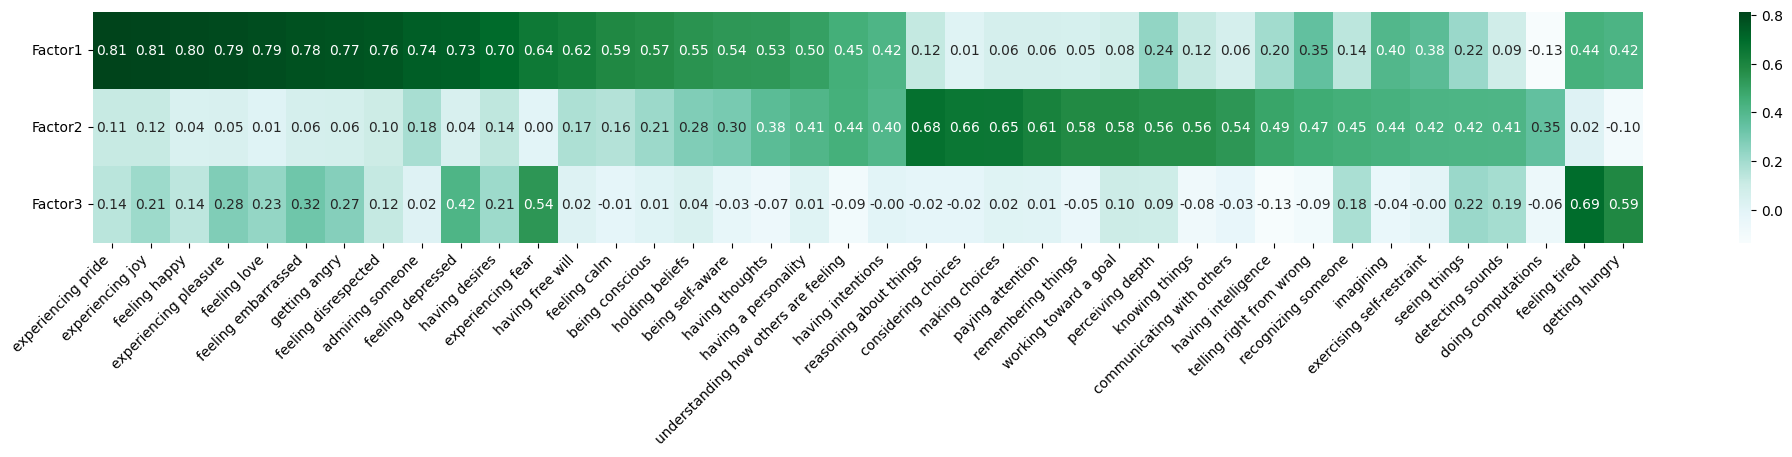

<Figure size 640x480 with 0 Axes>

In [15]:
# loadings = utils.read_file(loading_csv_path)
# item_order = utils.read_file(item_order_path)  # This item order is based on order from single-items
loading_csv_path = os.path.join(data_driven_save_dir, 'loadings.csv')
def load_factor_analysis_csv(loading_csv_path):
    loading_df = utils.read_file(loading_csv_path)

    # Map names to python compatible names
    items = utils.read_file(items_path)
    item_mapping = dict(zip(loading_df['Unnamed: 0'], items))
    loading_df['Unnamed: 0'] = loading_df['Unnamed: 0'].apply(lambda x: item_mapping[x])
    column_mapper = {'Unnamed: 0': 'item'}
    for i in range(n_factors):
        column_mapper['ML{}'.format(i + 1)] = 'Factor{}'.format(i + 1)

    loading_df = loading_df.rename(columns=column_mapper)
    return loading_df

loading_df = load_factor_analysis_csv(loading_csv_path)

# Assign categories based on maximum factor loading
loading_df_categories = assign_categories(
    df=loading_df,
    item_colname='item',
    save_dir=data_driven_save_dir,
    overwrite=True
)

item_order = sort_by_loadings(
    loading_df=loading_df_categories,
    factors=['Factor{}'.format(i) for i in range(n_factors, 0, -1)]
)

# Visualize loadings
analysis.visualize_loadings(
    loading_df=loading_df,
    n_components=n_factors,
    orientation='horizontal',
    keepcol_name='Factor',
    item_order=item_order,
    save_dir=data_driven_save_dir,
    save_ext=save_ext)



#### Compute IOU with other factor groupings

In [6]:
fa_groupings_json_path = os.path.join(data_driven_save_dir, 'fa_groupings.json')
fa_groupings = utils.read_file(fa_groupings_json_path)['factor_analysis']

theoretical_groupings = utils.read_file(groupings_path)
weisman_groupings = theoretical_groupings['weisman']
colombatto_groupings = theoretical_groupings['colombatto']

def categorization_ious(categorizations1, categorizations2):
    n_cats1 = len(categorizations1)
    n_cats2 = len(categorizations2)
    for cat1, cat1_items in categorizations1.items():
        for cat2, cat2_items in categorizations2.items():
            cat1_set = set(cat1_items)
            assert len(cat1_set) == len(cat1_items)
            cat2_set = set(cat2_items)
            assert len(cat2_set) == len(cat2_items)
            iou = len(cat1_set.intersection(cat2_set)) / len(cat1_set.union(cat2_set))

            utils.informal_log("{} and {} IOU: {}".format(
                cat1, cat2, iou
            ))
            utils.informal_log("{} items in {} but not {}:\n{}".format(
                len(cat1_set.difference(cat2_set)), cat1, cat2, cat1_set.difference(cat2_set)))
            utils.informal_log("{} items in {} but not {}:\n{}".format(
                len(cat2_set.difference(cat1_set)), cat2, cat1, cat2_set.difference(cat1_set)))

            print("")
categorization_ious(
    categorizations1=fa_groupings,
    categorizations2=colombatto_groupings
)

[0103_094456] Factor1 and experience IOU: 0.6896551724137931
[0103_094456] 1 items in Factor1 but not experience:
{'having thoughts'}
[0103_094456] 8 items in experience but not Factor1:
{'getting hungry', 'seeing things', 'feeling tired', 'exercising self-restraint', 'perceiving depth', 'detecting sounds', 'telling right from wrong', 'imagining'}

[0103_094456] Factor1 and intelligence IOU: 0.03125
[0103_094456] 20 items in Factor1 but not intelligence:
{'being conscious', 'being self-aware', 'feeling embarrassed', 'experiencing fear', 'feeling depressed', 'experiencing pride', 'having desires', 'experiencing joy', 'feeling love', 'having free will', 'understanding how others are feeling', 'feeling calm', 'experiencing pleasure', 'holding beliefs', 'having intentions', 'admiring someone', 'feeling disrespected', 'having a personality', 'feeling happy', 'getting angry'}
[0103_094456] 11 items in intelligence but not Factor1:
{'paying attention', 'knowing things', 'communicating with ot

### K-Fold 

In [ ]:
%%R

k_fold_bic <- function(rating_df, k, max_n_factors,
                           rotate, fm, scores, seed,
                           save_dir, overwrite) {

    if (!is.null(save_dir)) {
        
        bic_save_path <- sprintf('%s/bic.csv', save_dir)
        if (file.exists(bic_save_path) && !overwrite) {
            print(sprintf("File exists at %s", bic_save_path))
            return(read.csv(bic_save_path))
        }
    }
    fold_size = ceiling(nrow(rating_df) / k)
    print(sprintf("With %d folds and %d rows, %d rows per fold", k, nrow(rating_df), fold_size))
    # shuffle data
    set.seed(seed)
    shuffled_idxs <- sample(nrow(rating_df))
    
    bic_df = data.frame()

    # Iterate through folds
    for (k_idx in seq(1:k)) {
        test_idxs <- shuffled_idxs[(((k_idx-1)*fold_size)+1):(k_idx*fold_size)]
        test <- rating_df[test_idxs,]
        # Exclude test idxs
        train = rating_df[-test_idxs,]
        
        for (n_factors in seq(1:max_n_factors)) {
            
            fa_results = fa(
                r = train,
                nfactors = n_factors,
                rotate = rotate,
                fm = fm,
                scores = scores)
            if (n_factors == 1) {
                variance_explained = fa_results$Vaccounted[2, n_factors]
            }
            else{
                variance_explained = fa_results$Vaccounted[3, n_factors]
            }
            
            bic_df <- bind_rows(
                bic_df,
                data.frame(
                    fold = k_idx,
                    n_factors = n_factors,
                    bic = fa_results[['BIC']],
                    variance_explained = variance_explained
                )
            )
        }
    }

    if (!is.null(save_dir)) {
        write.csv(bic_df, bic_save_path, row.names = FALSE)
        print(sprintf("Saving bic_df to %s", bic_save_path))
    }
    return(bic_df)
}

bic_df <- k_fold_bic(
    rating_df = rating_df,
    k = k,
    max_n_factors = max_n_factors,
    rotate = rotate,
    fm = fm,
    scores = scores,
    seed = sample_seed,
    save_dir = k_fold_save_dir,
    overwrite = TRUE
)

[1] "With 5 folds and 470 rows, 94 rows per fold"
                      ML1
SS loadings    11.9894244
Proportion Var  0.2997356
                             ML1       ML2
SS loadings           10.5103531 6.6913579
Proportion Var         0.2627588 0.1672839
Cumulative Var         0.2627588 0.4300428
Proportion Explained   0.6110063 0.3889937
Cumulative Proportion  0.6110063 1.0000000
                             ML1       ML2        ML3
SS loadings           10.2471027 6.1740370 1.83916227
Proportion Var         0.2561776 0.1543509 0.04597906
Cumulative Var         0.2561776 0.4105285 0.45650755
Proportion Explained   0.5611683 0.3381125 0.10071916
Cumulative Proportion  0.5611683 0.8992808 1.00000000
                             ML1       ML2        ML3        ML4
SS loadings           10.6907538 5.8993152 1.69352324 0.94378545
Proportion Var         0.2672688 0.1474829 0.04233808 0.02359464
Cumulative Var         0.2672688 0.4147517 0.45708980 0.48068444
Proportion Explained   0.55601

[0103_105042] Saved graph to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/kfold/bic.pdf


(<Figure size 400x500 with 1 Axes>,
 <Axes: title={'center': 'BIC Using Varying Number of Factors'}, xlabel='Number of Factors', ylabel='Bayesian Information Criterion'>)

<Figure size 640x480 with 0 Axes>

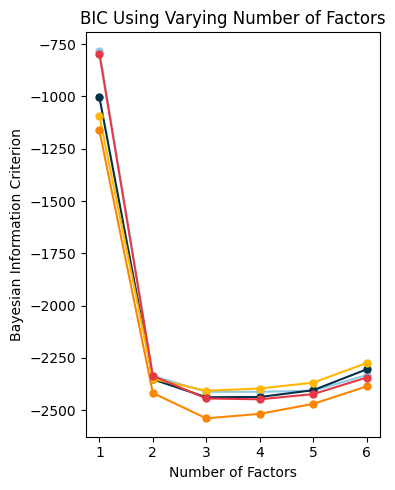

In [8]:
# Make bic_df graph in python
bic_csv_path = os.path.join(k_fold_save_dir, 'bic.csv')
bic_df = utils.read_file(bic_csv_path)

bic_graph_save_path = os.path.join(k_fold_save_dir, 'bic.{}'.format(save_ext))

# n_folds x n_factors
xs = bic_df.pivot(index='fold', columns='n_factors', values='n_factors').to_numpy()
ys = bic_df.pivot(index='fold', columns='n_factors', values='bic').to_numpy()


visualizations.plot(
    xs=xs,
    ys=ys,
    title='BIC Using Varying Number of Factors'.format(k),
    ylabel='Bayesian Information Criterion',
    xlabel='Number of Factors',
    fig_size=(4,5),
    save_path=bic_graph_save_path
)

[0102_162205] Saved graph to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/kfold/variance.pdf


(<Figure size 400x500 with 1 Axes>,
 <Axes: title={'center': 'Varianced Explained Using Varying Number of Factors'}, xlabel='Number of Factors', ylabel='Variance Explained'>)

<Figure size 640x480 with 0 Axes>

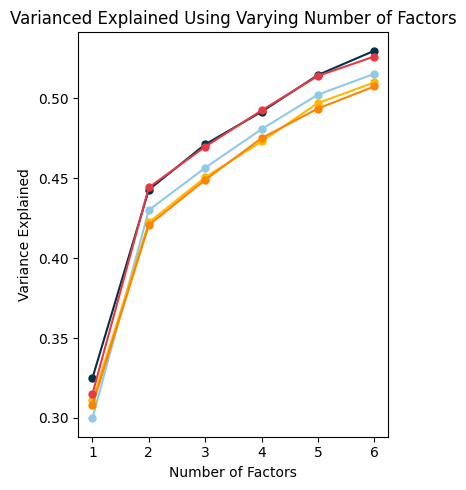

In [70]:
# Make variance explained graph in python
bic_csv_path = os.path.join(k_fold_save_dir, 'bic.csv')
bic_df = utils.read_file(bic_csv_path)

var_explained_graph_save_path = os.path.join(k_fold_save_dir, 'variance.{}'.format(save_ext))
# n_folds x n_factors
xs = bic_df.pivot(index='fold', columns='n_factors', values='n_factors').to_numpy()
ys = bic_df.pivot(index='fold', columns='n_factors', values='variance_explained').to_numpy()


visualizations.plot(
    xs=xs,
    ys=ys,
    title='Varianced Explained Using Varying Number of Factors'.format(k),
    ylabel='Variance Explained',
    # ylimits=(0, 1),
    xlabel='Number of Factors',
    fig_size=(4, 5),
    save_path=var_explained_graph_save_path
)

In [13]:
%%R

mse <- k_fold_mse(
    rating_df = rating_df,
    k = k,
    rotate = rotate,
    fm = fm,
    scores = scores,
    seed = sample_seed,
    save_dir = k_fold_save_dir,
    overwrite = TRUE,
    save_loadings = TRUE
)
print(mse)


[1] "With 5 folds and 470 rows, 94 rows per fold"
[1] "Saving loadings to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/kfold/loadings_fold1.csv"
[1] "Saving loadings to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/kfold/loadings_fold2.csv"
[1] "Saving loadings to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/kfold/loadings_fold3.csv"
[1] "Saving loadings to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/kfold/loadings_fold4.csv"
[1] "Saving loadings to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/kfold/loadings_fold5.csv"
[1] "Saving metrics to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/fact

### Use binarized theoretical Weisman Groupings to get Predictions


In [15]:
def create_loading_matrix(groupings,
                          grouping_source,
                          grouping_version,
                          item_order,
                          save_dir=None,
                          overwrite=False):
    '''
    Given groupings, create theoretical binary loading matrix

    Arg(s):
        groupings : dict[str : dict[str : list[str]]]
        grouping_srouce : str
        item_order : list[str]

    '''
    if save_dir is not None:
        save_path = os.path.join(save_dir, '{}_{}_binary_loadings.csv'.format(grouping_source, grouping_version))
        if os.path.exists(save_path) and not overwrite:
            utils.informal_log("Found file at {}".format(save_path))
            return utils.read_file(save_path).drop(columns='item').to_numpy()
        
    grouping = groupings[grouping_source]
    n_categories = len(grouping.keys())
    item_category_dict = {}
    for key, vals in grouping.items():
        for val in vals:
            item_category_dict[val] = key

    category_idx_dict = dict(zip(grouping.keys(), range(n_categories)))
    loadings = []
    for item in item_order:
        loading = np.zeros(n_categories)
        category_idx = category_idx_dict[item_category_dict[item]]
        loading[category_idx] = 1
        loadings.append(loading)
        # print(item, loading)

    loadings = np.stack(loadings, axis=0)
    
    if save_dir is not None:
        loadings_df = pd.DataFrame(loadings, columns=grouping.keys())
        loadings_df['item'] = item_order
        utils.write_file(loadings_df, save_path, overwrite=overwrite)

    return loadings

weisman_theory_loadings = create_loading_matrix(
    groupings=groupings,
    grouping_source=grouping_source,
    grouping_version=grouping_version,
    item_order=items,
    save_dir='dependent_variables')

weisman_theory_factor_scores, weisman_theory_predictions = compute_factor_scores(
    responses=rating_df.T,
    loadings=weisman_theory_loadings,
    return_predictions=True)

mse = mean_squared_error(weisman_theory_predictions.T, normalized_ratings)

utils.informal_log("MSE of binarized theory loadings: {}".format(mse))

Saved file to dependent_variables/weisman_absolute_study4_binary_loadings.csv
[1224_095542] Normalizing responses
[1224_095542] MSE of binarized theory loadings: 13.40748116482672


### Compare Weisman Loadings vs our Loadings on overlapping items

In [16]:
%%R
overlap_fa_save_dir <- sprintf("%s/overlap_items", save_dir)
ensure_dir(overlap_fa_save_dir)

Directory already exists: data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/overlap_items 


In [17]:
# Clean Weisman loading table
def clean_table(tab1_path,
                keep_items,
                keep_study=4,
                save_dir=None,
                overwrite=False):
    
    if save_dir is not None:
        save_path = os.path.join(save_dir, 'weisman_loadings.csv')
        if os.path.exists(save_path) and not overwrite:
            utils.informal_log("Weisman loadings at {}".format(save_path))
            return utils.read_file(save_path)
    t1 = utils.read_file(tab1_path)
    keep_columns = ['Item']
    col_mapping = {
        'Item': 'item'
    }
    for col in t1.columns:
        if str(keep_study) in col:
            keep_columns.append(col)
            # Store column rename
            col_mapping[col] = col.split(' ')[0].lower()
    
    t1 = t1[keep_columns]
    

    # Clean column names
    t1 = t1.rename(columns=col_mapping)
    # Rename items
    t1['item'] = t1['item'].apply(lambda x: x.replace('*', '').replace(' ^(†)', '').replace(' ^(+)', '').replace('\n', ' ').lower())

    # Select items that overlap and in the order presented
    n_overlap = len(set(t1['item']).intersection(set(keep_items)))
    assert n_overlap == 34

    t1 = t1[t1['item'].isin(keep_items)]
    assert len(t1) == n_overlap
    t1['item'] = pd.Categorical(t1['item'], categories=keep_items)
    t1 = t1.sort_values('item')
    
    if save_dir is not None:
        utils.write_file(t1, save_path)
    return t1
    
def clean_data(rating_df,
                overlap_items):
    
    overlap_rating_df = rating_df[rating_df.columns.intersection(overlap_items)]
    return overlap_rating_df

weisman_loadings = clean_table(
    tab1_path=weisman_loadings_path,
    keep_items=items,
    keep_study=weisman_loading_study,
    save_dir=overlap_fa_save_dir,
    overwrite=True)

assert weisman_loadings.shape == (34, 4)
# Get items from response data that correspond with items in both studies
overlap_items = weisman_loadings['item'].to_list()
overlap_rating_df = rating_df[rating_df.columns.intersection(overlap_items)]
assert overlap_rating_df.shape == (len(rating_df), len(weisman_loadings))
overlap_rating_csv_path = os.path.join(overlap_fa_save_dir, 'overlap_item_ratings.csv')
utils.write_file(overlap_rating_df, overlap_rating_csv_path)

# Compute factor scores using Weisman loadings
overlap_factor_scores, overlap_predictions = compute_factor_scores(
    responses=overlap_rating_df.T,
    loadings=weisman_loadings.drop(columns='item'),
    return_predictions=True)

normalized_overlap_rating_df = normalize_data(overlap_rating_df.T)
mse = mean_squared_error(normalized_overlap_rating_df, overlap_predictions)
print("MSE using Weisman loadings: {}".format(mse))

Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/overlap_items/weisman_loadings.csv
Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/overlap_items/overlap_item_ratings.csv
[1224_095600] Normalizing responses
MSE using Weisman loadings: 1.0979032510295363


Index(['heart', 'mind', 'body', 'item'], dtype='object')
[1224_095602] Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/overlap_items/weisman_study1_loadings.pdf


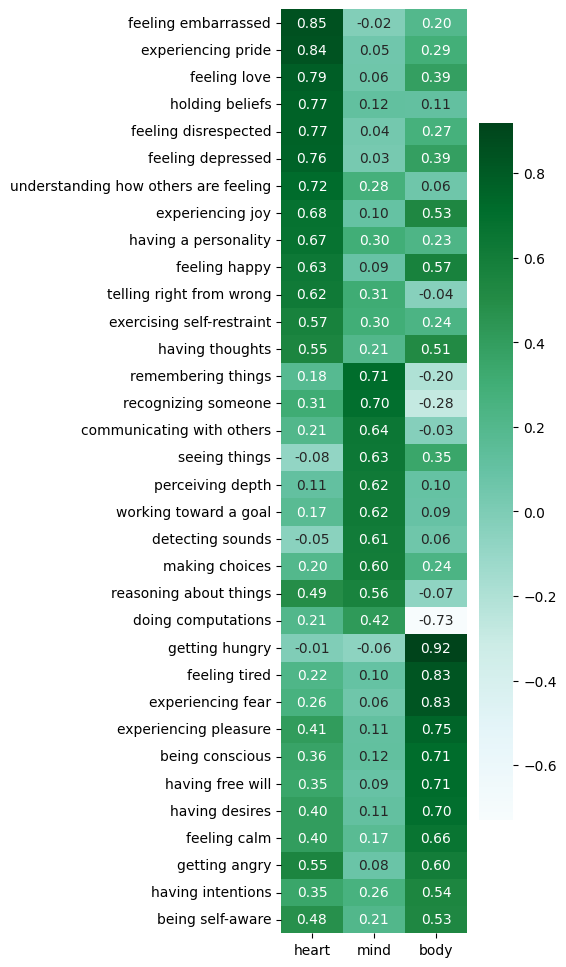

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize Weisman loadings
weisman_loadings_categories = assign_categories(
    df=weisman_loadings,
    item_colname='item'
)
item_order = sort_by_loadings(
    loading_df=weisman_loadings_categories,
    factors=['body', 'mind', 'heart']
)

analysis.visualize_loadings(
    loading_df=weisman_loadings_categories,
    n_components=n_factors,
    keep_columns=['heart', 'mind', 'body'],
    item_order=item_order,
    save_dir=overlap_fa_save_dir,
    filename='weisman_study{}_loadings'.format(weisman_loading_study),
    save_ext='pdf')


#### Run data driven FA using only items that the Weisman loadings overlap with

##### K-Fold

In [19]:
%%R

overlap_rating_csv_path <- sprintf("%s/overlap_item_ratings.csv", overlap_fa_save_dir)
overlap_rating_df <- read.csv(overlap_rating_csv_path)

overlap_k_fold_save_dir <- sprintf("%s/%d_fold", overlap_fa_save_dir, k)
ensure_dir(overlap_k_fold_save_dir)
print(sprintf("%d-fold results:", k))


k_fold_overlap_fa_results <- k_fold_mse(
    rating_df = overlap_rating_df,
    k = k,
    rotate = rotate,
    fm = fm,
    scores = scores,
    seed = sample_seed,
    save_dir = overlap_k_fold_save_dir,
    overwrite = TRUE,
    save_loadings = TRUE
)
print(k_fold_overlap_fa_results)


Directory created: data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/overlap_items/5_fold 
[1] "5-fold results:"
[1] "With 5 folds and 470 rows, 94 rows per fold"
[1] "Saving loadings to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/overlap_items/5_fold/loadings_fold1.csv"
[1] "Saving loadings to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/overlap_items/5_fold/loadings_fold2.csv"
[1] "Saving loadings to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/overlap_items/5_fold/loadings_fold3.csv"
[1] "Saving loadings to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/overlap_items/5_fold/loadings_fold4.csv"
[1] "Saving loadings to data/pilot_v3_1114

    Factor1   Factor2   Factor3                       item
0  0.464777 -0.067301  0.472213             getting hungry
1  0.030556  0.473319  0.054046  communicating with others
2  0.781376  0.127628  0.256529        feeling embarrassed
3  0.763552  0.147033  0.114650              feeling happy
4  0.192715  0.535358  0.218373           perceiving depth
Index(['Factor1', 'Factor2', 'Factor3', 'item'], dtype='object')


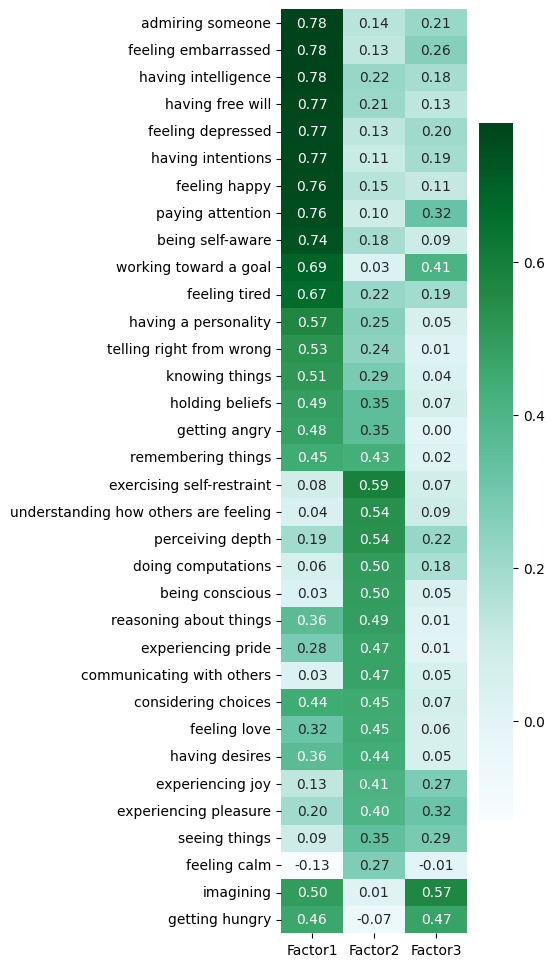

<Figure size 640x480 with 0 Axes>

In [24]:
# Visualize mean loading across folds
overlap_kfold_loading_csv_template = 'data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute/decomposition/factor_analysis/3_components/overlap_items/5_fold/loadings_fold{}.csv'

loadings = []
items = None
for i in range(1, k + 1):
    overlap_kfold_loading_csv_path = overlap_kfold_loading_csv_template.format(i)
    loading = utils.read_file(overlap_kfold_loading_csv_path)
    if items is None:
        items = loading['Unnamed: 0']
    loading = loading.drop(columns='Unnamed: 0')
    loading = loading.to_numpy()
    loadings.append(loading)

    

loadings = np.stack(loadings, axis=0)
mean_loadings = np.mean(loadings, axis=0)

factor_columns = ['Factor{}'.format(i) for i in range(1, n_factors + 1)]
loading_df = pd.DataFrame(
    mean_loadings, 
    columns=factor_columns)

# Map names to python compatible names
items_python = utils.read_file(items_path)
item_mapping = dict(zip(items, items_python))
loading_df['item'] = items.apply(lambda x: item_mapping[x])
print(loading_df.head())

loading_df_categories = assign_categories(
    df=loading_df,
    item_colname='item',
    save_dir=None
)
factor_columns.reverse()
item_order = sort_by_loadings(
    loading_df=loading_df_categories,
    factors=factor_columns
)

# Visualize loadings
analysis.visualize_loadings(
    loading_df=loading_df,
    n_components=n_factors,
    keepcol_name='Factor',
    item_order=item_order,
)

In [21]:
%%R
print("Single run")
single_run_overlap_save_dir <- sprintf("%s/single_run", overlap_fa_save_dir)
ensure_dir(single_run_overlap_save_dir)
overlap_fa_results <- data_driven_fa(
    rating_df = overlap_rating_df,
    n_factors = n_factors,
    rotate = rotate,
    fm = fm,
    scores = scores,
    save_dir = single_run_overlap_save_dir,
    overwrite = TRUE
)
print(overlap_fa_results$metrics)


[1] "Single run"
Directory created: data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/overlap_items/single_run 


[1] "Saved files in data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/overlap_items/single_run"
$bic
[1] -1637.379

$mse
[1] 0.4940107

$variance
                            ML1       ML2        ML3
SS loadings           9.4247617 4.4174564 2.15671496
Proportion Var        0.2771989 0.1299252 0.06343279
Cumulative Var        0.2771989 0.4071241 0.47055685
Proportion Explained  0.5890869 0.2761094 0.13480367
Cumulative Proportion 0.5890869 0.8651963 1.00000000



Index(['item', 'Factor1', 'Factor2', 'Factor3'], dtype='object')
Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/data_fa/loading_w_factors.csv
Index(['Factor1', 'Factor2', 'Factor3', 'item'], dtype='object')


/n/fs/ac-aiexhibit/explain-anthro-llm/src/analysis.py:2708: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loading_df['rank'] = loading_df[item_colname].map(order_mapping)


[1224_095745] Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/overlap_items/single_run/loadings.pdf


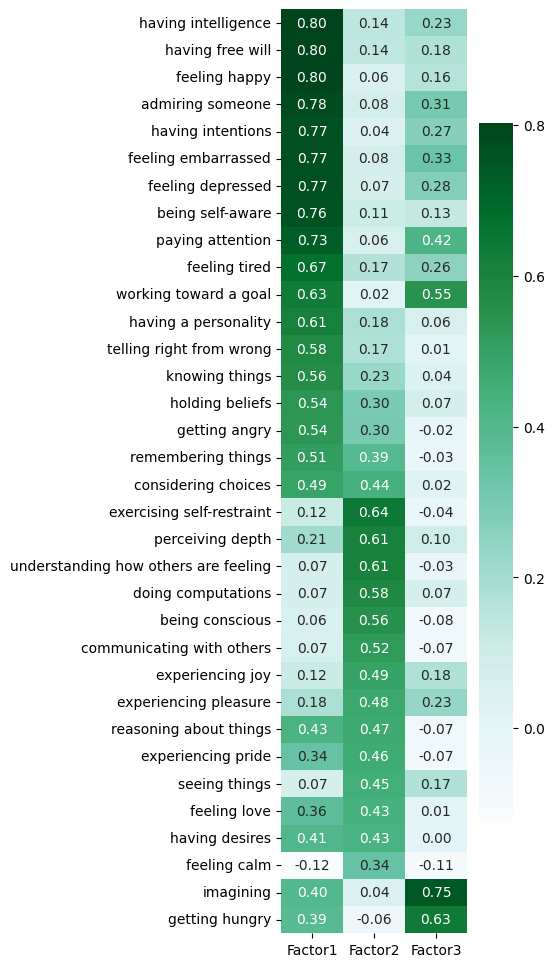

<Figure size 640x480 with 0 Axes>

In [22]:
single_run_overlap_save_dir = os.path.join(overlap_fa_save_dir, 'single_run')
loading_csv_path = os.path.join(single_run_overlap_save_dir, 'loadings.csv')
loading_df = utils.read_file(loading_csv_path)

# Map names to python compatible names
items = utils.read_file(items_path)
item_mapping = dict(zip(loading_df['Unnamed: 0'], items))
loading_df['Unnamed: 0'] = loading_df['Unnamed: 0'].apply(lambda x: item_mapping[x])
column_mapper = {'Unnamed: 0': 'item'}
for i in range(n_factors):
    column_mapper['ML{}'.format(i + 1)] = 'Factor{}'.format(i + 1)

loading_df = loading_df.rename(columns=column_mapper)
print(loading_df.columns)
# Assign categories based on maximum factor loading
loading_df_categories = assign_categories(
    df=loading_df,
    item_colname='item',
    save_dir=data_driven_save_dir,
    overwrite=True
)

item_order = sort_by_loadings(
    loading_df=loading_df_categories,
    factors=['Factor{}'.format(i) for i in range(3, 0, -1)]
)

# Visualize loadings
analysis.visualize_loadings(
    loading_df=loading_df,
    n_components=n_factors,
    keepcol_name='Factor',
    item_order=item_order,
    save_dir=single_run_overlap_save_dir,
    save_ext='pdf')



### NMF in R

In [ ]:
%%R
library(NMF)
nmf_save_dir <- sprintf("%s/nmf", save_dir)
ensure_dir(nmf_save_dir)

data_driven_nmf <- function(rating_df, n_factors, 
                   save_dir = NULL, overwrite = TRUE) {
    if (!is.null(save_dir)) {
        loadings_save_path <- sprintf("%s/loadings.csv", save_dir)
        factor_scores_save_path <- sprintf("%s/factor_scores_T.csv", save_dir)
        predictions_save_path <- sprintf("%s/predictions_T.csv", save_dir)
        metrics_save_path <- sprintf("%s/metrics.json", save_dir)
        if (file.exists(loadings_save_path) && 
            file.exists(factor_scores_save_path) && 
            file.exists(predictions_save_path) && 
            file.exists(metrics_save_path) && 
            !overwrite) {
            cat("Files already exist in :", save_dir, "\n")

            return(list(
                loadings = read.csv(loadings_save_path),
                factor_scores = read.csv(factor_scores_save_path),
                predictions = read.csv(predictions_save_path),
                metrics = fromJSON(metrics_save_path)
            ))
        }
    }
    if (requireNamespace("Biobase", quietly=TRUE)) {
        nmf_results <- nmf(rating_df, n_factors)

        # W : factor scores (n_participants x n_factors)
        W <- basis(nmf_results)
        # H : loadings (n_factors x n_items)
        H <- coef(nmf_results)
        # n_participants x n_items
        predictions <- fitted(nmf_results)
        
        mse_array <- (rating_df - predictions) ^ 2
        write.csv(mse_array, 'temp.csv')
        mse <- mean(as.matrix(mse_array))

        metrics <- list(
            mse = mse
        )

        # Save to files
        if (!is.null(save_dir)) {
            write.csv(H, loadings_save_path)
            write.csv(W, factor_scores_save_path)
            write.csv(predictions, predictions_save_path)
            write_json(metrics, metrics_save_path)
            print(sprintf("Saved files in %s", save_dir))
        }
        
        return(list(
            loadings = H,
            factor_scores = W,
            predictions = predictions,
            metrics = metrics
        ))
    }
}

nmf_results <- data_driven_nmf(
    rating_df = rating_df,
    n_factors = n_factors,
    save_dir = nmf_save_dir,
    overwrite = TRUE
)
print(sprintf("MSE: %f", nmf_results$metrics$mse))

Directory already exists: data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute/decomposition/factor_analysis/3_components/nmf 


[1] "matrix" "array" 
[1] "Saved files in data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute/decomposition/factor_analysis/3_components/nmf"
[1] "MSE: 1.270096"


In [54]:
# Assign factor categories using NMF loadings
nmf_save_dir = os.path.join(save_dir, 'nmf')
nmf_loading_csv_path = os.path.join(nmf_save_dir, 'loadings.csv')
nmf_loadings = utils.read_file(nmf_loading_csv_path)

# Drop index column
nmf_loadings = nmf_loadings.drop(columns='Unnamed: 0')
nmf_loadings = nmf_loadings.T.rename(
    columns=dict(zip(
        [i for i in range(n_factors)],
        ['Factor{}'.format(i+1) for i in range(n_factors)])))
nmf_loadings = nmf_loadings.reset_index()
nmf_loadings = nmf_loadings.rename(columns={'index': 'item'})
print(nmf_loadings.head())

_ = assign_categories(
    df=nmf_loadings,
    item_colname='item',
    save_dir=nmf_save_dir,
    overwrite=True
)



                        item   Factor1   Factor2   Factor3
0             getting.hungry  0.105286  0.093216  0.112053
1  communicating.with.others  0.168402  0.725872  0.730686
2        feeling.embarrassed  0.225689  0.093093  0.071533
3              feeling.happy  0.276734  0.104536  0.046973
4           perceiving.depth  0.220323  0.276618  0.482469
Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute/decomposition/factor_analysis/3_components/nmf/loading_w_factors.csv


### Re-perform R EMMeans analysis with new categorizations by factor loadings

#### Prepare CSVs for EMMeans Analysis

In [11]:
fa_groupings_path = os.path.join(data_driven_save_dir, 'fa_groupings.json')
fa_groupings = utils.read_file(fa_groupings_path)
rating_df = utils.read_file(rating_csv_path)

analysis.prepare_R_df(
    rating_df=rating_df,
    groupings=fa_groupings,
    save_dir=R_csv_dir,
    separate_groups=False,
    overwrite=True)

Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/data_fa/R_csvs/factor_analysis.csv


#### Graphing after EMMeans

Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4/decomposition/factor_analysis/3_components/data_fa/R_results/graphs/factor_analysis_emmeans_condition_by_group.csv
Baseline Factor1
     condition  emmean      SE     df  lower.CL  upper.CL    group
0     Baseline    1.68  0.0731  560.0     1.535      1.82  Factor1
1  Mechanistic    1.53  0.0737  560.0     1.383      1.67  Factor1
2   Functional    1.67  0.0728  560.0     1.523      1.81  Factor1
3  Intentional    2.15  0.0734  560.0     2.002      2.29  Factor1
4     Baseline    4.47  0.0747  609.0     4.328      4.62  Factor2
Baseline Factor2
     condition  emmean      SE     df  lower.CL  upper.CL    group
0     Baseline    1.68  0.0731  560.0     1.535      1.82  Factor1
1  Mechanistic    1.53  0.0737  560.0     1.383      1.67  Factor1
2   Functional    1.67  0.0728  560.0     1.523      1.81  Factor1
3  Intentional    2.15  0.0734  560.0     2.002      2.29  Factor1
4     Baseline    4.47  0.

<Figure size 640x480 with 0 Axes>

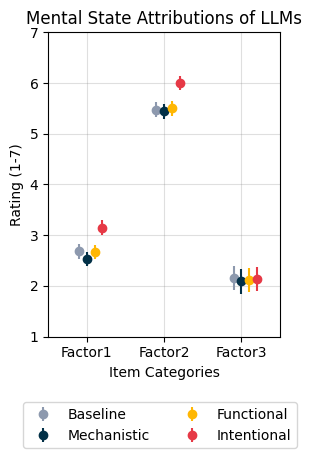

In [12]:
fa_groupings_path = os.path.join(data_driven_save_dir, 'fa_groupings.json')
fa_groupings = utils.read_file(fa_groupings_path)
groups = list(fa_groupings['factor_analysis'].keys())
conditions = ['Baseline', 'Mechanistic', 'Functional', 'Intentional']

plot_type = 'pointplot'
orientation = 'vertical' # Only relevant for pointplot

r_results_path = os.path.join(
    R_results_dir, 
    '{}_components_results.txt'.format(n_factors))
if not os.path.exists(r_results_path):
    raise ValueError("Path to R results file {} does not exist".format(r_results_path))

graph_save_dir = os.path.join(R_results_dir, 'graphs')
utils.ensure_dir(graph_save_dir)
emmeans_graph_data, emmeans_df = analysis.read_emmeans_marginalized_result(
    results_path=r_results_path,
    grouping_source="factor_analysis",
    conditions=['Baseline', 'Mechanistic', 'Functional', 'Intentional'],
    marginalized_var="group",
    marginalized_var_values=groups,
    save_dir=graph_save_dir,
    overwrite=True
)

if plot_type == 'bargraph':
    analysis.grouped_bar_graphs(
        groups=groups,
        grouping_source='{}_components'.format(n_factors),
        conditions=['Baseline', 'Mechanistic', 'Functional', 'Intentional'],
        graph_data=emmeans_graph_data,
        ci_dim='both',
        jitter_dim=None,
        line_start=None,
        save_dir=graph_save_dir,
        save_ext='pdf')
elif plot_type == 'pointplot':
    # Data prep copied from analysis.ipynb > Graph from EMMeans Output > Category Level Pointplots (separate by condition)
    pivot_df = analysis._format_and_pivot_emmeans_df(
        emmeans_df=emmeans_df,
        target_column='group'
    )
    means = pivot_df[["mean-{}".format(condition) for condition in conditions]].to_numpy().T
    errors = pivot_df[["ci_error-{}".format(condition) for condition in conditions]].to_numpy().T

    if orientation == 'horizontal':
        ytick_labels = [label.capitalize() for label in pivot_df['group'].to_list()]
        ylabel = 'Item Categories'
        xtick_labels = [i for i in range(1, 8)]
        xlabel = 'Rating (1-7)'
        fig_size = (7, 3)
    else:
        xtick_labels = [label.capitalize() for label in pivot_df['group'].to_list()]
        xlabel = 'Item Categories'
        ytick_labels = [i for i in range(1, 8)]
        ylabel = 'Rating (1-7)'
        fig_size = (3, 4)
        xlim = (-0.5, 2.5)
        ylim = None
    fig_save_path = os.path.join(
        graph_save_dir,
        'fa_category_graph_{}.{}'.format(orientation, save_ext))
    fig, ax = visualizations.pointplot(
        means=means,
        errors=errors,
        orientation=orientation,
        labels=conditions,
        ytick_labels=ytick_labels,
        xtick_labels=xtick_labels,
        xlabel=xlabel,
        ylabel=ylabel,
        ylim=ylim,
        xlim=xlim,
        title='Mental State Attributions of LLMs',
        show_legend=False,
        # legend_loc='upper right',
        fig_size=fig_size,
        color_idxs=[7, 1, 2, 4], # Copied from analysis.ipynb > Make save_dirs
        marker_size=10,
        show_grid=True,
        save_path=None,
        show=False)
    
    fig.legend(loc='lower center', bbox_to_anchor=(0.55, -0.15), ncol=2)
    utils.informal_log("Saving graph to {}".format(fig_save_path))
    plt.savefig(fig_save_path, bbox_inches="tight")

    plt.show()
else:
    raise ValueError("plot_type {} not recognized".format(plot_type))


### DD FA all in Python (semi old)

In [41]:
# n_factors = 3
# rating_csv_path = 'data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute/ratings.csv'
# items_path = 'dependent_variables/randomized_dvs_40/shuffled_0.txt'
# save_dir = os.path.join(os.path.dirname(rating_csv_path), 'decomposition', 'factor_analysis', '{}_components'.format(n_factors))

# loading_csv_path = os.path.join(save_dir, 'loadings.csv')
# # For graphing
# item_order_path = os.path.join(os.path.dirname(rating_csv_path), 'R_results/emmeans_graphs/item_order.txt')

# # Theoretical groupings
# groupings_path = 'dependent_variables/groupings_colombatto_absolute.json'
# grouping_source = 'weisman'

# utils.ensure_dir(save_dir)

# # Load ratings and items and select columns for items
# rating_df = utils.read_file(rating_csv_path)
# items = utils.read_file(items_path)
# rating_df = rating_df.loc[:, items]

# groupings = utils.read_file(groupings_path)

# assert(rating_df.shape == (470, 40))

# normalized_ratings = pd.DataFrame(
#     normalize_data(rating_df.to_numpy().T).T,
#     columns=items)

# # rating_array = rating_df.to_numpy().T
# # normalized_rating_array = normalize_data(rating_df.T)

# utils.write_file(
#     normalized_ratings,
#     os.path.join(os.path.dirname(rating_csv_path), 'normalized_ratings.csv'),
#     overwrite=True)

Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute/normalized_ratings.csv


In [78]:
def perform_fa(n_factors,
               rating_df,
               save_dir=None,
               overwrite=False):
    if save_dir is not None:
        # loading_save_path = os.path.join(save_dir, 'loadings.csv')
        factor_scores_save_path = os.path.join(save_dir, 'factor_scores_T.csv')
        prediction_save_path = os.path.join(save_dir, 'predictions_T.csv')
        metrics_path = os.path.join(save_dir, 'metrics.json')
        if os.path.exists(loading_csv_path) and \
            os.path.exists(factor_scores_save_path) and \
            os.path.exists(prediction_save_path) and \
            os.path.exists(metrics_path) and \
            not overwrite:
            return utils.read_file(loading_csv_path), utils.read_file(factor_scores_save_path), utils.read_file(prediction_save_path), utils.read_file(metrics_path)
        
    fa = factor_analyzer.FactorAnalyzer(
        n_factors=n_factors,
        rotation='varimax',
        method='ml'
    )
    fa_results = fa.fit(rating_df)
    loadings = fa_results.loadings_

    factor_scores, predictions = compute_factor_scores(
        responses=rating_df.to_numpy().T,
        loadings=loadings,
        return_predictions=True
    )

    factor_columns = ['Factor{}'.format(i+1) for i in range(n_factors)]
    loadings = pd.DataFrame(loadings, columns=factor_columns)
    loadings['factor'] = loadings.idxmax(axis=1)
    loadings.insert(0, 'item', rating_df.columns)

    # n_factors x n_participants -> n_participants x n_factors
    factor_scores = pd.DataFrame(factor_scores.T, columns=factor_columns)
    # n_items x n_participants -> n_participants x n_items
    predictions = pd.DataFrame(predictions.T, columns=rating_df.columns)
    
    normalized_ratings = normalize_data(rating_df.T).T
    mse = mean_squared_error(normalized_ratings, predictions)
    metrics = {
        'mse': mse
    }
    print(metrics)

    if save_dir is not None:
        utils.write_file(loadings, loading_csv_path, overwrite=overwrite)
        utils.write_file(factor_scores, factor_scores_save_path, overwrite=overwrite)
        utils.write_file(predictions, prediction_save_path, overwrite=overwrite)
        utils.write_file(metrics, metrics_path, overwrite=overwrite)
    
    return loadings, factor_scores, predictions, metrics

loadings, factor_scores, predictions, metrics = perform_fa(
    n_factors=n_factors,
    rating_df=rating_df,
    save_dir=save_dir,
    overwrite=True)
    

[1218_180807] Normalizing responses
{'mse': np.float64(0.5100898960459684)}
Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute/decomposition/factor_analysis/3_components/loadings.csv
Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute/decomposition/factor_analysis/3_components/factor_scores_T.csv
Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute/decomposition/factor_analysis/3_components/predictions_T.csv
Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute/decomposition/factor_analysis/3_components/metrics.json


## OLD Set up to run factor analysis (also has some code for NMF)

In [29]:
config = {
    'grouping_version': 'absolute',
    'data_dir': 'data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute',
    'mode': 'factor_analysis',
    'n_components': 3,
    'hparams': {},
    'conditions': ['Baseline', 'Mechanistic', 'Functional', 'Intentional'],
    # Factor modeling parameters
    'k_fold': 5,
    'split_data_seed': 123
}
config['rating_csv_path'] = os.path.join(config['data_dir'] , 'ratings.csv')

# Create save dir
config['save_dir'] = os.path.join(
    config['data_dir'], 'decomposition', config['mode'], 
    '{}_components'.format(config['n_components']))
utils.ensure_dir(config['save_dir'])

config['component_assignments_path'] = os.path.join(
    config['save_dir'],
    '{}_components_groupings.json'.format(config['n_components']))

config_save_path = os.path.join(config['save_dir'], 'config.json')
utils.write_file(config, config_save_path, overwrite=True)

# Hparams for FA
if config['mode'] == 'factor_analysis':
    config['hparams']['rotation'] = 'varimax'
# Hparams for NMF
elif config['mode'] == 'nmf':
    config['hparams']['max_iter'] = 500
else:
    raise ValueError("Decomposition mode '{}' not supported".format(config['mode']))

Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute/decomposition/factor_analysis/3_components/config.json


### Run Decomposition

#### Determine number of factors

In [ ]:
# rating_path = os.path.join(config['data_dir'], 'ratings.csv')
# items_path = 'dependent_variables/full_list_40.txt'

# items = utils.read_file(items_path)
# rating_df = utils.read_file(rating_path)

# rating_df = rating_df.loc[:, items]
# n_factorss = [i for i in range(1, 30)]
# print(n_factorss)
# for n_factors in n_factorss:
#     fa_df, fa_stats = analysis.perform_FA(
#         ratings=rating_df,
#         n_components=n_factors,
#         items=items,
#         return_stats=True)
    
#     utils.informal_log("N factors: {} log-likelihood: {:.4f} BIC: {:.4f}".format(
#         n_factors, fa_stats['log_likelihood'], fa_stats['bic']
#     ))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[1209_100428] N factors: 1 log-likelihood: -29217.5152 BIC: 58441.1830
[1209_100428] N factors: 2 log-likelihood: -28098.2829 BIC: 56208.8713
[1209_100428] N factors: 3 log-likelihood: -27176.3802 BIC: 54371.2187
[1209_100428] N factors: 4 log-likelihood: -26439.0100 BIC: 52902.6310
[1209_100428] N factors: 5 log-likelihood: -25777.5167 BIC: 51585.7971
[1209_100428] N factors: 6 log-likelihood: -25122.2096 BIC: 50281.3356
[1209_100428] N factors: 7 log-likelihood: -24405.1641 BIC: 48853.3974
[1209_100428] N factors: 8 log-likelihood: -23722.7350 BIC: 47494.6918
[1209_100429] N factors: 9 log-likelihood: -22970.2432 BIC: 45995.8611
[1209_100429] N factors: 10 log-likelihood: -22154.4532 BIC: 44370.4337
[1209_100429] N factors: 11 log-likelihood: -21394.0098 BIC: 42855.6996
[1209_100429] N factors: 12 log-likelihood: -20541.4609 BIC: 41156.7545
[1209_100429] N factors: 13 log-likel

#### Run FA or NMF

In [75]:
groupings_path = 'dependent_variables/groupings_colombatto_{}.json'.format(config['grouping_version'])
rating_path = os.path.join(config['data_dir'], 'ratings.csv')
items_path = 'dependent_variables/full_list_40.txt'

items = utils.read_file(items_path)
rating_df = utils.read_file(rating_path)

# Select items, convert to array, and transpose to n_items x n_participants
rating_array = rating_df.loc[:, items].to_numpy().T

# fa_df : n_items X n_components + 2 (one for item, one for factor assignment)
factor_loadings, fa_df, fa_metrics, fa_obj = analysis.perform_decomposition(
    responses=rating_array,
    mode=config['mode'],
    n_components=config['n_components'],
    items=items,
    hparams=config['hparams'],
    return_obj=True,
    save_dir=config['save_dir'])
print(fa_metrics)
factor_scores, predictions = analysis.compute_factor_scores(
    responses=rating_array,
    loadings=factor_loadings,
    return_predictions=True)

normalized_rating_array = analysis.normalize_data(rating_array)
mse = mean_squared_error(predictions, normalized_rating_array)
print(mse)

(40, 470)
[1216_114742] Normalizing responses
[1216_114742] Mode: factor_analysis Hyper-parameters: {'rotation': 'varimax'}
Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute/decomposition/factor_analysis/3_components/3_components.csv
Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute/decomposition/factor_analysis/3_components/3_components_metrics.json
Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute/decomposition/factor_analysis/3_components/3_components_groupings.json
{'avg_log_likelihood': np.float64(-452.0257103054044), 'bic': np.float64(922.5096186949211), 'mean_covariance': 0.0010156384010108833, 'mean_precision': 0.006360568702739463, 'assignment': {'Factor1': ['having intentions', 'being self-aware', 'holding beliefs', 'understanding how others are feeling', 'having a personality', 'telling right from wrong', 'exercising self-restraint', 'having thoughts', 'remembering things', 'perceivi

### Decomposition Analysis:
* loading visualization
* Compare grouping to theory groupings
* Prep and run mixed effects models with new groups

#### Visualize loading matrix

#### Data prep for Mixed Effects Models

In [5]:
# grouping = utils.read_file(config['component_assignments_path'])
# groupings = {
#     '{}_components'.format(config['n_components']): grouping
# }
# rating_df = utils.read_file(config['rating_csv_path'])

# # Make R directories
# R_save_dir = os.path.join(config['save_dir'], 'R_csvs')
# utils.ensure_dir(R_save_dir)
# # Make a directory to output results from R
# R_results_save_dir = os.path.join(config['save_dir'], 'R_results')
# utils.ensure_dir(R_results_save_dir)
# # Make a directory for item-level analyses with R
# item_level_R_results_save_dir = os.path.join(config['save_dir'], 'R_results', 'item_level')
# utils.ensure_dir(item_level_R_results_save_dir)

# utils.informal_log("Preparing DFs for R analysis")
# analysis.prepare_R_df(
#     rating_df=rating_df,
#     groupings=groupings,
#     save_dir=R_save_dir,
#     separate_groups=False,
#     overwrite=True)

[1203_102844] Preparing DFs for R analysis
Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute/factor_analysis/2_components/R_csvs/2_components.csv


#### Graph EMMeans AFTER running R file `src/mixed_effect_model_interaction.R`

Saved file to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute/factor_analysis/2_components/R_results/2_components_results.csv
[1, 2, 3, 4, 5, 6, 7]
4
[1203_102848] Saved graph to data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute/factor_analysis/2_components/graphs/group_graph_2_components-jitter_None-ci_both.pdf


<Figure size 640x480 with 0 Axes>

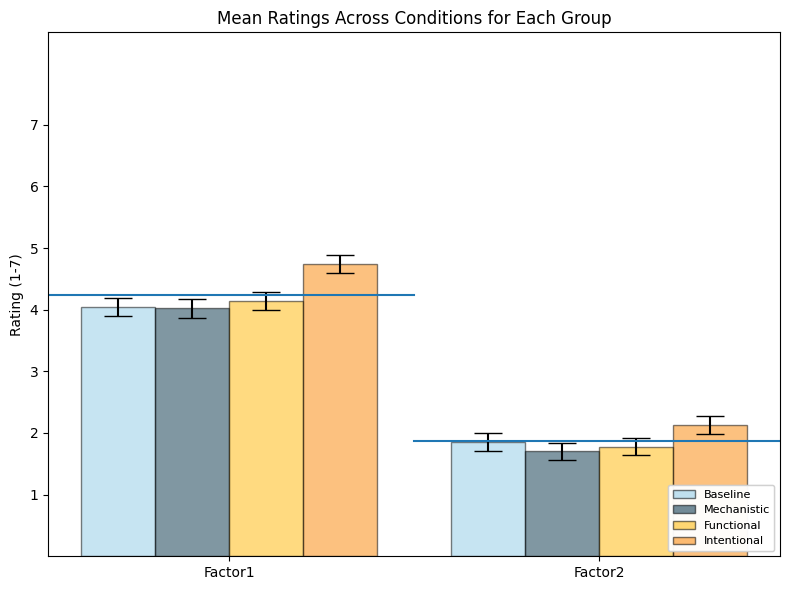

In [6]:
# groups = list(grouping.keys())
# r_results_path = os.path.join(
#     R_results_save_dir, 
#     '{}_components_results.txt'.format(config['n_components']))
# if not os.path.exists(r_results_path):
#     raise ValueError("Path to R results file {} does not exist".format(r_results_path))

# graph_save_dir = os.path.join(config['save_dir'], 'graphs')
# utils.ensure_dir(graph_save_dir)
# emmeans_graph_data, emmeans_df = analysis.read_emmeans_result(
#     results_path=r_results_path,
#     conditions=config['conditions'],
#     save_dir=R_results_save_dir,
#     overwrite=True
# )

# analysis.grouped_bar_graphs(
#     groups=groups,
#     grouping_source='{}_components'.format(config['n_components']),
#     conditions=config['conditions'],
#     graph_data=emmeans_graph_data,
#     ci_dim='both',
#     jitter_dim=None,
#     line_start=None,
#     save_dir=graph_save_dir,
#     save_ext='pdf')